# Time series forecasting using PyTorch Transformer

The goal is to predict future sequence values (real numbers) in generative manner. To be more precise, there are known past values $\mathbf{X} = \{x_0, x_1, \ldots , x_N\}$ (inputs) and the model predicts future values $\mathbf{Y} = \{\hat{x}_{N+1}, \hat{x}_{N+2}, \ldots , \hat{x}_{N+M}\}$. PyTorch Transformer is adopted since it should be ideal for the task. Transformer is used to generate the new values by iteratively using the known values and already generated samples:

 * $y_1$ = Transformer($\mathbf{X},y_0$)
 * $y_2$ = Transformer($\mathbf{X},y_0, y_1$)
 * $y_3$ = Transformer($\mathbf{X},y_0, y_1, y_2$)

New symbol $y_i$ is used instead of $\hat{x}_{N+j}$ to more explicitly discriminate between the known and generated sequences. The first prediction, $y_0$, is often the *start of sequence* symbol `<SOS>`.

**Transformer** Transformer is a neural architecture that is considered as the golden standard for sequence-to-sequence modeling. However, thanks to ChatGPT and other large language models (LLMs) most texts about programming with transformers are related to natural language processing (NLP). Another branch are texts about how to implement Transformer from the scratch. There are less posts about how to use the existing Transformer models for generic real valued data prediction instead of language.

In the following, we build the final model step by step starting from *SimplestTransformer* to *TimeSeriesTransformer*. The covered steps add one at time of the essential building blocks:

 * Tokenization
 * Embedding and unembedding
 * Masked attention
 * Position encoding
 * Quantized real value embedding
 * Direct real value prediction

For more information about them, check the Transformer Wiki page: https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)

## Torch.nn.Transformer

It seems that the generic Transformer module of PyTorch is becoming depricated, but since it is used in many example codes it is used as the main module.

Fundamental imports are the following and this code is tested on Python 3.12.2 and everything installed through Linux Conda package manager.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import math
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt

import platform

print(platform.python_version())

3.12.2


## SimplestTransformer - As simpe as possible and what we can do with it

What can we do with the simplest possible transformer architecture that does not include anything else but the transformer itself.

Let's construct a SimplestTransformer class that has [nn.torch.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) as member.

The following model takes a sequence (e.g. [0, 0, 0, 0]) as input, puts it through torch.nn.Transformer gives its outputs directly as output.

**Note:** The only additional change to the default parameters is `norm_first = True` since the original plain transformer architecture had difficulty converging, but it was later found that doing normalization *before* multiheaded attention stabilizes learning (no heatup with increasing learning rate needed in the beginning of training)


In [545]:
class SimplestTransformer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps
    ):
        super().__init__()

        # Transformer initialized with user specs
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
    ):
        # Transformer assumes that src & tgt structure is (seq_length, batch_num, feat_dim)
        out = self.transformer(src, tgt)

        return out

Let's define SimpleTransformer with sminimal settings. Everything is one, but to make the linear feedforward part to have any meaning, we assign 8 neurons there.

In [546]:
model = SimplestTransformer(d_model = 1, nhead = 1, num_encoder_layers = 1, num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1, layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 88 parameters (88 trainable)


**Training data**

Let's start with two symbols only:

 * 0
 * 1

The two symbols can be used in binary sequences. The simplest task is perhaps to continue the sequences. The training data is

 * X: 0, 0, 0 $\rightarrow$ Y: 0, 0, 0
 * X: 1, 1, 1 $\rightarrow$ Y: 1, 1, 1

In [547]:
def generate_data1(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 3

    data = []

    for i in range(n // 2):
        X = np.ones(length)
        y = np.ones(length)
        data.append([X, y])

    for i in range(n // 2):
        X = np.zeros(length)
        y = np.zeros(length)
        data.append([X, y])

    np.random.shuffle(data)

    return data

Run several times to make sure both types of sequences are generated

In [548]:
tr_data = generate_data1(100)

print(tr_data[0][0])
print(tr_data[0][1])

print(tr_data[1][0])
print(tr_data[1][1])

print(tr_data[2][0])
print(tr_data[2][1])

[1. 1. 1.]
[1. 1. 1.]
[0. 0. 0.]
[0. 0. 0.]
[1. 1. 1.]
[1. 1. 1.]


Form training matrices of ```Seq len x Num samples x Feat dim```

In [549]:
X_tr = torch.empty((len(tr_data[0][0]),len(tr_data),1))
Y_tr = torch.empty((len(tr_data[0][1]),len(tr_data),1))
for ids, s in enumerate(tr_data):
    X_tr[:,ids,0] = torch.from_numpy(s[0])
    Y_tr[:,ids,0] = torch.from_numpy(s[1])
print(X_tr.shape)

print(X_tr[:,0,0])
print(Y_tr[:,0,0])

print(X_tr[:,1,0])
print(Y_tr[:,1,0])

print(X_tr[:,2,0])
print(Y_tr[:,2,0])

torch.Size([3, 100, 1])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([0., 0., 0.])
tensor([0., 0., 0.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])


In [550]:
num_of_epochs = 1000
loss_mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    Y_in = Y_tr[:-1,:,:]
    Y_out = Y_tr[1:,:,:]
    Y_pred = model(X_tr,Y_in)
    loss = loss_mse(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 0.5 (lr=0.01)
   Epoch 100 training loss 0.2500151991844177 (lr=0.01)
   Epoch 200 training loss 0.25 (lr=0.01)
   Epoch 300 training loss 0.25 (lr=0.01)
   Epoch 400 training loss 0.25 (lr=0.01)
   Epoch 500 training loss 0.25 (lr=0.01)
   Epoch 600 training loss 0.25 (lr=0.01)
   Epoch 700 training loss 0.25 (lr=0.01)
   Epoch 800 training loss 0.25 (lr=0.01)
   Epoch 900 training loss 0.25 (lr=0.01)


In [560]:
def predict(model, input_sequence, max_length=16, SOS_token=2, EOS_token=3, EOS_plus = 2):

    model.eval()
    
    y_input = torch.tensor([SOS_token], dtype=torch.long)

    sos_found = False
    for _ in range(max_length):
        #print(f'X={input_sequence} Y={y_input}')

        # Get prediction
        pred = model(input_sequence, y_input)

        pred_tokens = torch.argmax(pred, dim=1)

        y_input = torch.cat((torch.tensor([SOS_token], dtype=torch.long), pred_tokens), dim=0)

        if pred_tokens[-1] == EOS_token:
            break

    return y_input.tolist()

Let's test what the model outputs

In [552]:
print(X_tr[:,40,0])
print(Y_pred[:,40,0])

tensor([1., 1., 1.])
tensor([0.5000, 0.5000], grad_fn=<SelectBackward0>)


**Findings:** The Transformer architecture is suitable for providing information about the most likely next token given the input sequence $\mathbf{X}$ and the current output sequence $\mathbf{Y}$. However, it the Transformer output itself is used as the next output sequence token, then it cannot do else but provide a single token that minimizes the mean squared error (MSE). In the case of equal amount of '1' and '0' as output it learns to predict 0.5 that is between the two values. You can change the values, e.g., to '0' and '10' to validate this finding.

To improve SimplestTransformer we must introduce a mapping from 'tokens' (sequence symbols) to an internal representation that carries out information about the best next token, and then again back to tokens. These two steps are called *embedding* and *unembedding*. They convert every token to a token specific vector (of the length `d_model`) and back. Embedding is a table lookup from 1 to model dimensional vector, but the vector representation can be optimized during training.

## SimpleTransformer - Add token embedding and un-embedding

At first, let's turn from integers to talk about *tokens*. The input and output sequences, $\textbf{X}$ and $\textbf{Y}$, are sequences of tokens with unique (integer) Id. Let's use the following tokens next:

```
Symbol 0 is 0
Symbol 1 is 1
Symbol <SOS> is 2 // Start of sequence
Symbol <EOS> is 3 // End of sequence
```

The SOS and EOS tokens help the transformer to learn the beginning and end of sequences.

Generate tokenized data

We have the following tokens:

 *       `0` : 0 
 *       `1` : 1 
 * `<SOS>` : 2
 * `<EOS>` : 3

Let's try to generate a single output from a sequence input

 * input: SOS,0,0,0,EOS  output: SOS,0,EOS
 * input: SOS,1,1,1,EOS  output: SOS,1,EOS

or vice versa

 * SOS,0,EOS -> SOS,0,0,0,EOS
 * SOS,1,EOS -> SOS,1,1,1,EOS

In [395]:
def generate_data2(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])

    data = []

    # 0,0,0,0 -> 1 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, [0, 0, 0], EOS_token))
        y = np.concatenate((SOS_token, [1], EOS_token))
        data.append([X, y])

    # 1,1,1,1 -> 0 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, [1, 1, 1], EOS_token))
        y = np.concatenate((SOS_token, [0], EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [553]:
def generate_data3(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])

    data = []

    # 1 -> 0,0,0,0 
    for i in range(n // 2):
        y = np.concatenate((SOS_token, [0, 0, 0, 0], EOS_token))
        X = np.concatenate((SOS_token, [1], EOS_token))
        data.append([X, y])

    # 1 -> 1,1,1,1 
    for i in range(n // 2):
        y = np.concatenate((SOS_token, [1, 1, 1, 1], EOS_token))
        X = np.concatenate((SOS_token, [0], EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [554]:
tr_data = generate_data3(100)

print(tr_data[0][0])
print(tr_data[0][1])

print(tr_data[1][0])
print(tr_data[1][1])

print(tr_data[2][0])
print(tr_data[2][1])

[2 1 3]
[2 0 0 0 0 3]
[2 0 3]
[2 1 1 1 1 3]
[2 0 3]
[2 1 1 1 1 3]


Generate training data tensors. Note that now we do not generate extra dimension (seq len x num samples x 1) for the tokens that are one-dimensional since embedding will add the requested number of dimensions (seq len x num samples x num feats).

In [555]:
X_tr = torch.empty((len(tr_data[0][0]),len(tr_data)))
Y_tr = torch.empty((len(tr_data[0][1]),len(tr_data)))
for ids, s in enumerate(tr_data):
    X_tr[:,ids] = torch.from_numpy(s[0])
    Y_tr[:,ids] = torch.from_numpy(s[1])
print(X_tr.shape)

print(X_tr[:,0])
print(Y_tr[:,0])

print(X_tr[:,1])
print(Y_tr[:,1])

print(X_tr[:,2])
print(Y_tr[:,2])

torch.Size([3, 100])
tensor([2., 1., 3.])
tensor([2., 0., 0., 0., 0., 3.])
tensor([2., 0., 3.])
tensor([2., 1., 1., 1., 1., 3.])
tensor([2., 0., 3.])
tensor([2., 1., 1., 1., 1., 3.])


Tokenization does not help as such, but for each token a special *embedding vector* can be generated. Embedding vector may carry more information than a single value.

**Note:** Unembedding is actually performed by a linear layer that converts the embedding vector to a vector with the same length as the number of tokens. Now, the next token selection becomes a classification task. We assume that the unembedding vector contains probabilities of each token. By using the *cross-entropy error* as loss function we can optimize this mapping. Note that [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) performs the soft-max operation internally and therefore it does not need to be part of the Transformer architecture.

In [556]:
class SimpleTransformer(nn.Module):
    # Constructor
    def __init__(
        self,
        num_tokens,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps
    ):
        super().__init__()

        self.d_model = d_model
        
        # Token embedding layer - this takes care of converting integer ids to vectors
        self.embedding = nn.Embedding(num_tokens, d_model)

        # Token "unembedding" to one-hot encoded token vector
        self.unembedding = nn.Linear(d_model, num_tokens)

        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True

        )

    def forward(
        self,
        src,
        tgt,
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)        

        # Transformer output
        out = self.transformer(src, tgt)
        out = self.unembedding(out)
        
        return out

In [557]:
model = SimpleTransformer(num_tokens = 4, d_model = 8, nhead = 1, num_encoder_layers = 1, num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1, layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 1332 parameters (1332 trainable)


In [558]:
num_of_epochs = 1000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.long()
    Y_in = Y_tr[:-1,:].long()
    Y_out = Y_tr[1:,:].long()
    Y_pred = model(X_in,Y_in)
    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len
    Y_pred = Y_pred.permute(1, 2, 0)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 10 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 1.340372920036316 (lr=0.01)
   Epoch 10 training loss 0.8127036094665527 (lr=0.01)
   Epoch 20 training loss 0.6399750709533691 (lr=0.01)
   Epoch 30 training loss 0.5244415402412415 (lr=0.01)
   Epoch 40 training loss 0.48644545674324036 (lr=0.01)
   Epoch 50 training loss 0.4820917844772339 (lr=0.01)
   Epoch 60 training loss 0.47530338168144226 (lr=0.01)
   Epoch 70 training loss 0.46358826756477356 (lr=0.01)
   Epoch 80 training loss 0.46134352684020996 (lr=0.01)
   Epoch 90 training loss 0.4614886939525604 (lr=0.01)
   Epoch 100 training loss 0.4553680121898651 (lr=0.001)
   Epoch 110 training loss 0.4542762339115143 (lr=0.001)
   Epoch 120 training loss 0.45668914914131165 (lr=0.001)
   Epoch 130 training loss 0.45848241448402405 (lr=0.001)
   Epoch 140 training loss 0.4633973240852356 (lr=0.001)
   Epoch 150 training loss 0.46021488308906555 (lr=0.001)
   Epoch 160 training loss 0.4602748155593872 (lr=0.001)
   Epoch 170 training loss 0.45115283131599426

In [561]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([2, 1, 1, 1, 3], dtype=torch.long),
    torch.tensor([2, 0, 0, 0, 3], dtype=torch.long),
    torch.tensor([2, 1, 3], dtype=torch.long),
    torch.tensor([2, 0, 3], dtype=torch.long)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [1, 1, 1]
Continuation: [1]

Example 1
Input: [0, 0, 0]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1]
Continuation: [1]

Example 3
Input: [0]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



**Findings**

Interestingly, the ```SimpleTransformer``` architecture learns to map long sequences to short, e.g., 0,0,0,0 -> 1 and 1,1,1,1 -> 0 , but not short sequences to long, e.g., 0 -> 1,1,1,1 and 1 -> 0,0,0,0.

The problem is that we train it incorrectly.

SimpleTransformer is trained with full sequences

 * SOS,1,EOS -> SOS,0,0,0,0,EOS
 * SOS,0,EOS -> SOS,1,1,1,1,EOS

 BUT during inference it only knows the input and what is generated so far

 * (SOS,1,EOS),(SOS) -> 0
 * (SOS,1,EOS),(SOS,0) -> 0,0
 * (SOS,1,EOS),(SOS,0,0) -> 0,0,0
 * (SOS,1,EOS),(SOS,0,0,0) -> 0,0,0,0
 * (SOS,1,EOS),(SOS,0,0,0,0) -> 0,0,0,0,EOS

This means that inference is different from training, and especially in the short-to-long case.

This can be fixed by **masking** the future outputs during taining. After this little extension the transformer is already pretty powerful model.

## SimpleTransformerPlus - Masking the future outputs during training

```SimpleTransformer```was able to learn to produce a single output from multiple, but not multiple outputs from single. The main reason for that is that there is discrepancy between the training data and test data. During training it was aware of the full future, i.e., its task was to learn to produce a missing token in the following cases

 * SOS,1,EOS -> SOS,?,0,0,,EOS
 * SOS,1,EOS -> SOS,0,?,0,EOS
 * SOS,1,EOS -> SOS,0,0,?,EOS
 * SOS,1,EOS -> SOS,0,0,0,?

while during testin the 'future' outputs are not known and the problem is actually


 * SOS,1,EOS -> SOS,?
 * SOS,1,EOS -> SOS,0,?
 * SOS,1,EOS -> SOS,0,0,?
 * SOS,1,EOS -> SOS,0,0,0,?

which is different from the training. Note that in the many-to-one case training and test cases are almost identical and that is why it worked.

**Solution:** During training we need to mask the future outputs. There is a pre-made Torch function for that

In [575]:
sequence_length = 10
tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
print(tgt_mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


Let's define ```SimpleTransformerPlus``` that supports masking.

In [576]:
class SimpleTransformerPlus(nn.Module):
    # Constructor
    def __init__(
        self,
        num_tokens,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps
    ):
        super().__init__()

        self.d_model = d_model
        
        # Token embedding layer - this takes care of converting integer to vectors
        self.embedding = nn.Embedding(num_tokens, d_model)

        # Token "unembedding" to one-hot token vector
        self.unembedding = nn.Linear(d_model, num_tokens)

        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)        

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask)
        out = self.unembedding(out)
        
        return out

In [591]:
model = SimpleTransformerPlus(num_tokens = 4, d_model = 8, nhead = 1, num_encoder_layers = 1, num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1, layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 1332 parameters (1332 trainable)


In [592]:
num_of_epochs = 2000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.long()
    Y_in = Y_tr[:-1,:].long()
    Y_out = Y_tr[1:,:].long()

    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    
    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)

    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    Y_pred = Y_pred.permute(1, 2, 0)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 1.3542481660842896 (lr=0.01)
   Epoch 100 training loss 0.4061003029346466 (lr=0.01)
   Epoch 200 training loss 0.3027517795562744 (lr=0.01)
   Epoch 300 training loss 0.23316869139671326 (lr=0.01)
   Epoch 400 training loss 0.266167551279068 (lr=0.01)
   Epoch 500 training loss 0.24914109706878662 (lr=0.001)
   Epoch 600 training loss 0.20288799703121185 (lr=0.001)
   Epoch 700 training loss 0.2525886595249176 (lr=0.001)
   Epoch 800 training loss 0.19239892065525055 (lr=0.001)
   Epoch 900 training loss 0.20035260915756226 (lr=0.001)
   Epoch 1000 training loss 0.17571181058883667 (lr=0.001)
   Epoch 1100 training loss 0.20941556990146637 (lr=0.001)
   Epoch 1200 training loss 0.20730094611644745 (lr=0.001)
   Epoch 1300 training loss 0.18186041712760925 (lr=0.001)
   Epoch 1400 training loss 0.216546431183815 (lr=0.001)
   Epoch 1500 training loss 0.1846693605184555 (lr=0.001)
   Epoch 1600 training loss 0.19660606980323792 (lr=0.001)
   Epoch 1700 training 

**Inference** must be updated as well for nn.Transformer since it re-produces all outputs sequentially, but without masking it "sees" the future that was not anymore allowed in training. 


In [3]:
def predict(model, input_sequence, max_length=16, SOS_token=2, EOS_token=3, EOS_plus = 2):

    model.eval()
    
    y_input = torch.tensor([SOS_token], dtype=torch.long)

    sos_found = False
    for _ in range(max_length):
        #print(f'X={input_sequence} Y={y_input}')

        sequence_length = len(y_input)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    
        pred = model(input_sequence, y_input, tgt_mask = tgt_mask)

        pred_tokens = torch.argmax(pred, dim=1)

        y_input = torch.cat((torch.tensor([SOS_token], dtype=torch.long), pred_tokens), dim=0)

        if pred_tokens[-1] == EOS_token:
            break

    return y_input.tolist()

In [593]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([2, 1, 1, 1, 3], dtype=torch.long),
    torch.tensor([2, 0, 0, 0, 3], dtype=torch.long),
    torch.tensor([2, 1, 3], dtype=torch.long),
    torch.tensor([2, 0, 3], dtype=torch.long)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [1, 1, 1]
Continuation: [0, 0, 0, 0]

Example 1
Input: [0, 0, 0]
Continuation: [1, 1, 1, 1]

Example 2
Input: [1]
Continuation: [0, 0, 0, 0]

Example 3
Input: [0]
Continuation: [1, 1, 1, 1]



Let's try something different - how about learning how to continue a sequence

* sos,0,1,0,1,eos $\rightarrow$ sos,0,1,0,1,eos
* sos,1,0,1,0,eos $\rightarrow$ sos,1,0,1,0,eos

The above looks simple enough so that ```SimpleTransformerPlus```should be able to learn it now that it can process sequences correctly

In [4]:
def generate_data4(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])

    data = []

    # 1 -> 0,0,0,0 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, [0, 1, 0, 1], EOS_token))
        y = np.concatenate((SOS_token, [0, 1, 0, 1], EOS_token))
        data.append([X, y])

    # 1 -> 1,1,1,1 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, [1, 0, 1, 0], EOS_token))
        y = np.concatenate((SOS_token, [1, 0, 1, 0], EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [5]:
tr_data = generate_data4(100)

print(tr_data[0][0])
print(tr_data[0][1])

print(tr_data[1][0])
print(tr_data[1][1])

print(tr_data[2][0])
print(tr_data[2][1])

[2 1 0 1 0 3]
[2 1 0 1 0 3]
[2 1 0 1 0 3]
[2 1 0 1 0 3]
[2 0 1 0 1 3]
[2 0 1 0 1 3]


In [6]:
X_tr = torch.empty((len(tr_data[0][0]),len(tr_data)))
Y_tr = torch.empty((len(tr_data[0][1]),len(tr_data)))
for ids, s in enumerate(tr_data):
    X_tr[:,ids] = torch.from_numpy(s[0])
    Y_tr[:,ids] = torch.from_numpy(s[1])
print(X_tr.shape)

print(X_tr[:,0])
print(Y_tr[:,0])

print(X_tr[:,1])
print(Y_tr[:,1])

print(X_tr[:,2])
print(Y_tr[:,2])

torch.Size([6, 100])
tensor([2., 1., 0., 1., 0., 3.])
tensor([2., 1., 0., 1., 0., 3.])
tensor([2., 1., 0., 1., 0., 3.])
tensor([2., 1., 0., 1., 0., 3.])
tensor([2., 0., 1., 0., 1., 3.])
tensor([2., 0., 1., 0., 1., 3.])


In [610]:
model = SimpleTransformerPlus(num_tokens = 4, d_model = 8, nhead = 1, num_encoder_layers = 1, num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1, layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 1332 parameters (1332 trainable)


In [611]:
num_of_epochs = 2000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.long()
    Y_in = Y_tr[:-1,:].long()
    Y_out = Y_tr[1:,:].long()

    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    
    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)

    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    Y_pred = Y_pred.permute(1, 2, 0)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 1.317150354385376 (lr=0.01)
   Epoch 100 training loss 0.3775438368320465 (lr=0.01)
   Epoch 200 training loss 0.40597498416900635 (lr=0.01)
   Epoch 300 training loss 0.21399351954460144 (lr=0.01)
   Epoch 400 training loss 0.5730879902839661 (lr=0.01)
   Epoch 500 training loss 0.4395396411418915 (lr=0.001)
   Epoch 600 training loss 0.27175191044807434 (lr=0.001)
   Epoch 700 training loss 0.2718021273612976 (lr=0.001)
   Epoch 800 training loss 0.24456676840782166 (lr=0.001)
   Epoch 900 training loss 0.24476777017116547 (lr=0.001)
   Epoch 1000 training loss 0.22980175912380219 (lr=0.001)
   Epoch 1100 training loss 0.20475421845912933 (lr=0.001)
   Epoch 1200 training loss 0.2261151522397995 (lr=0.001)
   Epoch 1300 training loss 0.2475406527519226 (lr=0.001)
   Epoch 1400 training loss 0.2095976322889328 (lr=0.001)
   Epoch 1500 training loss 0.2383974939584732 (lr=0.001)
   Epoch 1600 training loss 0.21962140500545502 (lr=0.001)
   Epoch 1700 training l

In [612]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([2, 0, 1, 0, 1, 3], dtype=torch.long),
    torch.tensor([2, 1, 0, 1, 0, 3], dtype=torch.long),
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 1, 0, 1]
Continuation: [1, 0]

Example 1
Input: [1, 0, 1, 0]
Continuation: [1, 0]



**Findings**

Despite of its power ```SimpleTransformer``` to predict future from past tokes, is not able to learn simple sequence continuation such as 0,1,0,1 -> 0,1,0,1 and 1,0,1,0 -> 1,0,1,0.

The reason is that the embeddings for the tokens 0 and 1 are the same, and summing them up is the same for 0,1,0,1 and 1,0,1,0 (and even for 1100, 1001, 0011) so the transformer does not know what is the correct.

In order to fix this problem we need to make Transformer aware about the position of each token. That can be done by

 * Positional encoding


## ATransformer - Positional encoding is the last missing ingredient

Plethora of code snippets can be found for positional encoding so let's pick one

In [8]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

The code shows that the encoding is additive so by inputting zero vectors we see how it works.

torch.Size([2, 9])


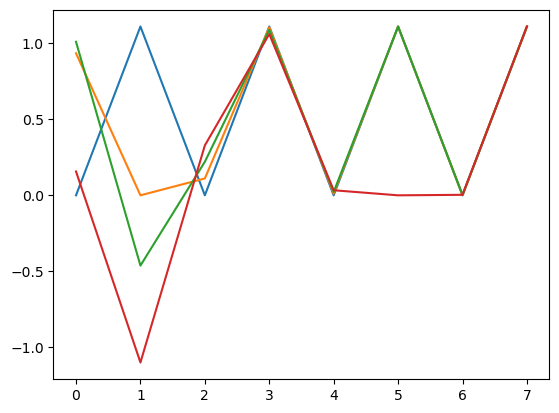

In [12]:
foo_x = torch.zeros((4,1,8))
foo_encoding = PositionalEncoding(8)
foo_x_enc = foo_encoding(foo_x)

plt.plot(np.squeeze(foo_x_enc).t())

In [74]:
class Transformer(nn.Module):
    # Constructor
    def __init__(
        self,
        num_tokens,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps
    ):
        super().__init__()

        self.d_model = d_model
        
        # Token embedding layer - this takes care of converting integer to vectors
        self.embedding = nn.Embedding(num_tokens, d_model)

        # Token "unembedding" to one-hot token vector
        self.unembedding = nn.Linear(d_model, num_tokens)

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=d_model, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            src = torch.unsqueeze(src,1) 
        src = self.positional_encoder(src)
        if tgt.dim() == 2: # seq len x feat dim
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.positional_encoder(tgt)

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask)
        out = self.unembedding(out)
        
        return out

In [75]:
model = Transformer(num_tokens = 4, d_model = 8, nhead = 1, num_encoder_layers = 1, num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1, layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 1332 parameters (1332 trainable)


In [90]:
num_of_epochs = 2000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.long()
    Y_in = Y_tr[:-1,:].long()
    Y_out = Y_tr[1:,:].long()

    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    
    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)

    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    Y_pred = Y_pred.permute(1, 2, 0)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')
print(f'Final:   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 0.9784363508224487 (lr=0.01)
   Epoch 100 training loss 0.10000507533550262 (lr=0.01)
   Epoch 200 training loss 0.033111266791820526 (lr=0.01)
   Epoch 300 training loss 0.05412794277071953 (lr=0.01)
   Epoch 400 training loss 0.012893409468233585 (lr=0.01)
   Epoch 500 training loss 0.008361301384866238 (lr=0.001)
   Epoch 600 training loss 0.008510332554578781 (lr=0.001)
   Epoch 700 training loss 0.0036712519358843565 (lr=0.001)
   Epoch 800 training loss 0.010958276689052582 (lr=0.001)
   Epoch 900 training loss 0.003900029929354787 (lr=0.001)
   Epoch 1000 training loss 0.008949804119765759 (lr=0.001)
   Epoch 1100 training loss 0.0043568965047597885 (lr=0.001)
   Epoch 1200 training loss 0.003931717947125435 (lr=0.001)
   Epoch 1300 training loss 0.011823654174804688 (lr=0.001)
   Epoch 1400 training loss 0.012323993258178234 (lr=0.001)
   Epoch 1500 training loss 0.02136898972094059 (lr=0.001)
   Epoch 1600 training loss 0.0018198979087173939 (lr=0.001)

In [91]:
def predict(model, input_sequence, max_length=16, SOS_token=2, EOS_token=3, EOS_plus = 2):

    model.eval()
    
    y_input = torch.tensor([SOS_token], dtype=torch.long)

    sos_found = False
    for _ in range(max_length):
        #print(f'X={input_sequence} Y={y_input}')

        sequence_length = len(y_input)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)

        pred = model(input_sequence, y_input, tgt_mask = tgt_mask)

        # Since the positional encoding implementation the model returns seq len x batch num x feat num
        if pred.dim() == 3:
            pred = torch.squeeze(pred,1)
        
        pred_tokens = torch.argmax(pred, dim=1)

        y_input = torch.cat((torch.tensor([SOS_token], dtype=torch.long), pred_tokens), dim=0)

        if pred_tokens[-1] == EOS_token:
            break

    return y_input.tolist()

In [92]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([2, 0, 1, 0, 1, 3], dtype=torch.long),
    torch.tensor([2, 1, 0, 1, 0, 3], dtype=torch.long),
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 1, 0, 1]
Continuation: [0, 1, 0, 1]

Example 1
Input: [1, 0, 1, 0]
Continuation: [1, 0, 1, 0]



**Findings** Works like a charm!


## Continuous data